# **Info**

**Project name:** Application that recommeds you movies according to your current emotional state

**Team members:**

Sanzhar Baltabekov IT-2201

Islam Sultan IT-2201

Adekhan Demenov IT-2201

# **Step 1 | Uploading dataset**

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name = fn, length = len(uploaded[fn])))

Saving archive.zip to archive.zip
User uploaded file "archive.zip" with length 63252113 bytes


# **Step 2 | Extracting dataset**

In [108]:
from zipfile import ZipFile
name_of_the_file = "archive.zip"

with ZipFile(name_of_the_file, 'r') as zip:
  zip.extractall()
  print("Dataset successfully extracted")

Dataset successfully extracted


# **Step 3 | Importing libraries**

In [114]:
import numpy as np
import cv2
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D
from keras.optimizers import Adam
from keras.layers import MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import requests
from keras.preprocessing import image
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
from keras.models import load_model

# **Step 4 | Training and validation data preparation**

In [115]:
training_directory = 'train'
validation_directory = 'test'
training_datagen = ImageDataGenerator(rescale = 1./255)
validation_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = training_datagen.flow_from_directory(
        training_directory,
        target_size = (48, 48),
        batch_size = 64,
        color_mode = "grayscale",
        class_mode = 'categorical')

val_generator = validation_datagen.flow_from_directory(
        validation_directory,
        target_size = (48,48),
        batch_size = 64,
        color_mode = "grayscale",
        class_mode = 'categorical')

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


# **Step 5 | CNN**

In [117]:
emotion_model = Sequential()
emotion_model.add(Conv2D(32, kernel_size = (3, 3), activation = 'relu', input_shape = (48, 48, 1)))
emotion_model.add(Conv2D(64, kernel_size = (3, 3), activation = 'relu'))
emotion_model.add(MaxPooling2D(pool_size = (2, 2)))
emotion_model.add(Dropout(0.25))
emotion_model.add(Conv2D(128, kernel_size = (3, 3), activation='relu'))
emotion_model.add(MaxPooling2D(pool_size = (2, 2)))
emotion_model.add(Conv2D(128, kernel_size = (3, 3), activation='relu'))
emotion_model.add(MaxPooling2D(pool_size = (2, 2)))
emotion_model.add(Dropout(0.25))
emotion_model.add(Flatten())
emotion_model.add(Dense(1024, activation = 'relu'))
emotion_model.add(Dropout(0.5))
emotion_model.add(Dense(7, activation = 'softmax'))

# **Step 6 | Training**

In [118]:
emotion_model.compile(loss = 'categorical_crossentropy',
                      optimizer = Adam(learning_rate = 0.0001),
                      metrics = ['accuracy'])

emotion_model_info = emotion_model.fit_generator(
        train_generator,
        steps_per_epoch = 28709 // 64,
        epochs = 50,
        validation_data = val_generator,
        validation_steps = 7178 // 64)

Epoch 1/50


<ipython-input-118-4cd5ea69fd8f>:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  emotion_model_info = emotion_model.fit_generator(


448/448 [==============================] - 20s 40ms/step - loss: 1.7991 - accuracy: 0.2603 - val_loss: 1.7034 - val_accuracy: 0.3514
Epoch 2/50
448/448 [==============================] - 19s 42ms/step - loss: 1.6159 - accuracy: 0.3680 - val_loss: 1.5320 - val_accuracy: 0.4128
Epoch 3/50
448/448 [==============================] - 13s 28ms/step - loss: 1.5130 - accuracy: 0.4188 - val_loss: 1.4509 - val_accuracy: 0.4533
Epoch 4/50
448/448 [==============================] - 20s 45ms/step - loss: 1.4326 - accuracy: 0.4510 - val_loss: 1.3719 - val_accuracy: 0.4788
Epoch 5/50
448/448 [==============================] - 14s 30ms/step - loss: 1.3681 - accuracy: 0.4812 - val_loss: 1.3523 - val_accuracy: 0.4847
Epoch 6/50
448/448 [==============================] - 18s 40ms/step - loss: 1.3184 - accuracy: 0.4999 - val_loss: 1.2888 - val_accuracy: 0.5126
Epoch 7/50
448/448 [==============================] - 16s 37ms/step - loss: 1.2755 - accuracy: 0.5173 - val_loss: 1.2620 - val_accuracy: 0.5174
Epo

# **Step 7 | Saving the model**

In [125]:
emotion_model.save('model.h5')

# **Step 8 | Keras**

In [126]:
emotion_model = load_model('model.h5')

# **Step 9 | Emotion analysis function**

In [121]:
objects = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')

max_emotion = ""

def emotion_analysis(emotions):
    global objects, max_emotion
    y_pos = np.arange(len(objects))

    plt.bar(y_pos, emotions, align = 'center', alpha = 0.5)
    plt.xticks(y_pos, objects)
    plt.ylabel('percentage')
    plt.title('emotion')

    max_emotion_index = np.argmax(emotions)

    max_emotion = objects[max_emotion_index]

    max_emotion_percentage = emotions[max_emotion_index] * 100
    plt.annotate(f'Max: {max_emotion} ({max_emotion_percentage:.2f}%)',
                 xy = (max_emotion_index, emotions[max_emotion_index]),
                 xytext = (max_emotion_index, emotions[max_emotion_index] + 0.05),
                 arrowprops = dict(facecolor = 'black', shrink = 0.05))

    plt.show()

# **Step 10 | Taking photo function**

In [122]:
def take_photo(filename = 'photo.jpg', quality = 0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

# **TAKE PHOTO**

In [175]:
take_photo()

<IPython.core.display.Javascript object>

'photo.jpg'

# **OUTPUT** | Emotion detection + movie recommendations

OpenCV(4.8.0) /io/opencv/modules/objdetect/src/cascadedetect.cpp:1689: error: (-215:Assertion failed) !empty() in function 'detectMultiScale'

1/1 [==============================] - 0s 18ms/step


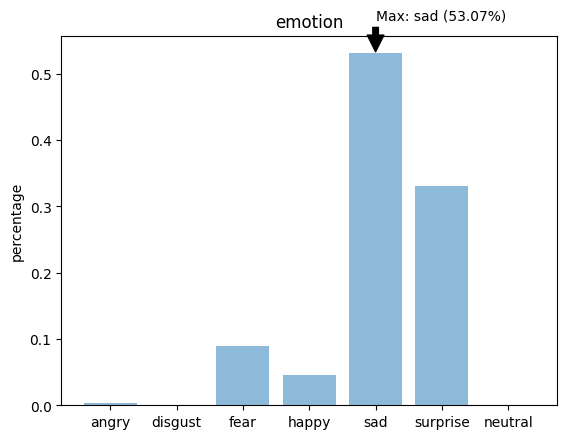

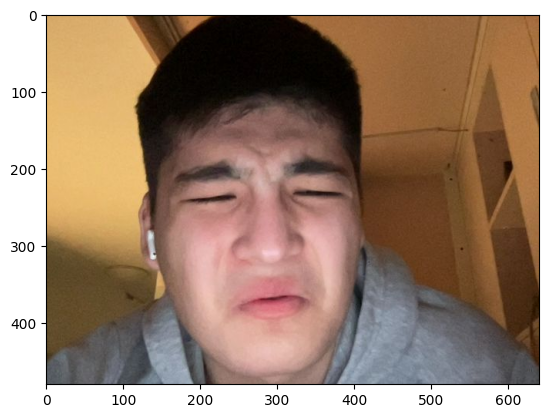

Your emotion is sad
Recommended Movies for Sad
The Beekeeper
Through My Window 3: Looking at You
Miller's Girl
#Blue_Whale
Oppenheimer
Trunk - Locked In
Spaceman
Napoleon
The Hunger Games: The Ballad of Songbirds & Snakes
The Inventor


In [176]:
def facecrop(image):
    facedata = '/content/haarcascade_frontalface_alt.xml'
    cascade = cv2.CascadeClassifier(facedata)

    img = cv2.imread(image)

    try:

        minisize = (img.shape[1],img.shape[0])
        miniframe = cv2.resize(img, minisize)

        faces = cascade.detectMultiScale(miniframe)

        for f in faces:
            x, y, w, h = [ v for v in f ]
            cv2.rectangle(img, (x,y), (x+w,y+h), (0,255,0), 2)

            sub_face = img[y:y+h, x:x+w]

            cv2.imwrite('capture.jpg', sub_face)

    except Exception as e:
        print (e)

if __name__ == '__main__':
    facecrop('/content/photo.jpg')

file = '/content/photo.jpg'
true_image = image.load_img(file)
img = image.load_img(file, color_mode="grayscale", target_size=(48, 48))

x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)

x /= 255

custom = emotion_model.predict(x)
emotion_analysis(custom[0])

x = np.array(x, 'float32')
x = x.reshape([48, 48]);

plt.imshow(true_image)
plt.show()
print("Your emotion is " + max_emotion)

def recommend_movies(emotion):
    api_key = 'bc6555c03527c134bdfd53d3d3b80c65'
    base_url = 'https://api.themoviedb.org/3'

    emotion_genre_mapping = {
        'angry': 28,  # Action
        'disgust': 80, # Crime
        'fear': 27,  # Horror
        'happy': 35,  # Comedy
        'sad': 18,  # Drama
        'surprise': 14, # Fantasy
        'neutral': 10751 # Family
    }

    genre_id = emotion_genre_mapping.get(emotion.lower())
    if genre_id is None:
        return ['No recommendations available for this emotion']

    url = f'{base_url}/discover/movie?api_key={api_key}&with_genres={genre_id}&sort_by=popularity.desc'
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        movies = [movie['title'] for movie in data.get('results', [])]
        return movies[:10]
    else:
        return ['Error fetching recommendations from the API']

emotion = max_emotion
recommended_movies = recommend_movies(emotion)
print("Recommended Movies for", emotion.capitalize())
if recommended_movies:
    for movie in recommended_movies:
        print(movie)
else:
    print("No recommendations available for this emotion")